In [1]:
import scipy.io as sci
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from skimage.measure import block_reduce
import statsmodels.api as sm
from statsmodels.formula.api import ols
import multiprocess as mp

%matplotlib inline 
%config Completer.use_jedi = False

In [2]:
data = sci.loadmat('DirectionTuning_V1_dec.mat')['data']
dirTuningExp = sci.loadmat('DirectionTuning_V1_dec.mat')['dirTuningExp']

## shape of the data
Nvert, Nhorz, Nframes = data.shape
labels = -1 * np.ones([Nframes, 1])
codes = dirTuningExp['tGratingDirectionDeg'][0][0][0]
Ntrials = dirTuningExp['nTrials'][0][0][0][0]
Noff = dirTuningExp['stimOffFrames'][0][0][0][0]
Non = dirTuningExp['stimOnFrames'][0][0][0][0]

offset = 0
for i in range(Ntrials):
    offset = offset + Noff
    labels[offset + np.array(range(Non))] = codes[i]
    offset = offset + Non

In [3]:
# Extracts stim/off frames based on "labels" and calculates mean across trials ... every 6/12 frames respectively
baseline_stim_frames = block_reduce(data[:, :, np.where(labels != -1)[0]], block_size=(1,1,6), func=np.mean)
baseline_off_frames = block_reduce(data[:, :, np.where(labels == -1)[0]], block_size=(1,1,12), func=np.mean)
difference_images = baseline_stim_frames - baseline_off_frames

In [4]:
orientation_values = codes.astype(int)
orientations = np.unique(orientation_values)

In [5]:
alpha = 0.05
tuning_cutoff = 0.33 

def tuning_anova(diff_image):
    temp_orientation = pd.DataFrame({"Difference_image": diff_image, "Orientation":orientation_values}) 
    p_value = sm.stats.anova_lm(ols('Difference_image ~ C(Orientation)', data=temp_orientation).fit(), typ=2)['PR(>F)'][0]
    if p_value >= alpha: return np.nan
    else:
        max_activation = orientation_values[diff_image.argmax()]
        preferred_activation = diff_image[orientation_values == max_activation].mean()
        orthogonal_activation = diff_image[orientation_values == abs(max_activation-180)].mean()
        tuning_index = 1 - (orthogonal_activation/preferred_activation)
        tuning_index = 1
        
        if (tuning_index > tuning_cutoff): return max_activation
        else: return np.nan

In [6]:
with mp.Pool(10) as pool:
    # Flattening difference image and casting function to calculate preferred direction 
    output = np.array(pool.map(tuning_anova, difference_images.reshape(-1, difference_images.shape[2])))

In [7]:
# Unflattenning image 
preferred_img = output.reshape(difference_images.shape[0], difference_images.shape[1])

/var/folders/9l/35n9s6_s0f3bmw4yz19gz84w0000gn/T/ipykernel_58649/56464190.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(orientations.astype(str))


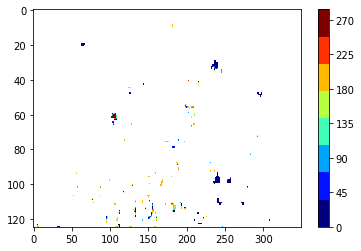

In [8]:
from matplotlib import cm
fig, ax = plt.subplots()
cmap = cm.get_cmap('jet', orientations.shape[0])
cax = ax.imshow(preferred_img, cmap = cmap, aspect = 'auto')
cbar = fig.colorbar(cax)
cbar.ax.set_yticklabels(orientations.astype(str))
plt.show()